Step 1: Setup in Google Colab

In [ ]:
# Run this first in Colab
!pip install torch torchvision matplotlib kagglehub opendatasets  -q

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

Step 2: Download Dataset

In [ ]:
# Download Cats vs Dogs dataset (simplified version)
import os
import zipfile
import urllib.request

# Create data directory
os.makedirs('data', exist_ok=True)

import opendatasets as od
dataset_url = "https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset"
od.download(dataset_url)

# The data will be in: ./kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages
data_dir = "./kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages"


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Brian Njugunazzz
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset


100%|██████████| 787M/787M [00:04<00:00, 203MB/s]


Step 3: Data Preparation (Dataset & DataLoader)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load and split (80/20)
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training: {len(train_dataset)}, Validation: {len(val_dataset)}")
print(f"Classes: {full_dataset.classes}")  # ['Cat', 'Dog']



Training: 19967, Validation: 4992
Classes: ['Cat', 'Dog']


Step 4: Simple CNN Model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   # 3 channels (RGB) -> 16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 16 -> 32
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 16 * 16, 64)  # After 2 poolings: 64/2/2 = 16
        self.fc2 = nn.Linear(64, 2)              # 2 classes: Cat or Dog
        self.dropout = nn.Dropout(0.5)           # Prevent overfitting

    def forward(self, x):
        # Conv block 1: 64x64 -> 32x32
        x = self.pool(self.relu(self.conv1(x)))
        # Conv block 2: 32x32 -> 16x16
        x = self.pool(self.relu(self.conv2(x)))
        # Flatten
        x = x.view(x.size(0), -1)
        # Fully connected
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = SimpleCNN().to(device)
print(model)

cuda
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=8192, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Step 5: Training with Validation & Metrics

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return running_loss / len(loader), accuracy

# Validation function
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')

    return running_loss / len(loader), accuracy, precision, recall

# Training loop
epochs = 5
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_prec, val_rec = validate(model, val_loader, criterion)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Val Precision: {val_prec:.4f}, Val Recall: {val_rec:.4f}")

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/5
  Train Loss: 0.6081, Train Acc: 0.6687
  Val Loss: 0.5439, Val Acc: 0.7268
  Val Precision: 0.7094, Val Recall: 0.7733


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 2/5
  Train Loss: 0.5230, Train Acc: 0.7434
  Val Loss: 0.4861, Val Acc: 0.7624
  Val Precision: 0.7786, Val Recall: 0.7371


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 3/5
  Train Loss: 0.4879, Train Acc: 0.7690
  Val Loss: 0.4654, Val Acc: 0.7728
  Val Precision: 0.8002, Val Recall: 0.7307


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 4/5
  Train Loss: 0.4616, Train Acc: 0.7880
  Val Loss: 0.4523, Val Acc: 0.7883
  Val Precision: 0.7694, Val Recall: 0.8267


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 5/5
  Train Loss: 0.4471, Train Acc: 0.7974
  Val Loss: 0.4464, Val Acc: 0.7915
  Val Precision: 0.7688, Val Recall: 0.8371


Step 6: Plot Training History (Debugging Unstable Training)

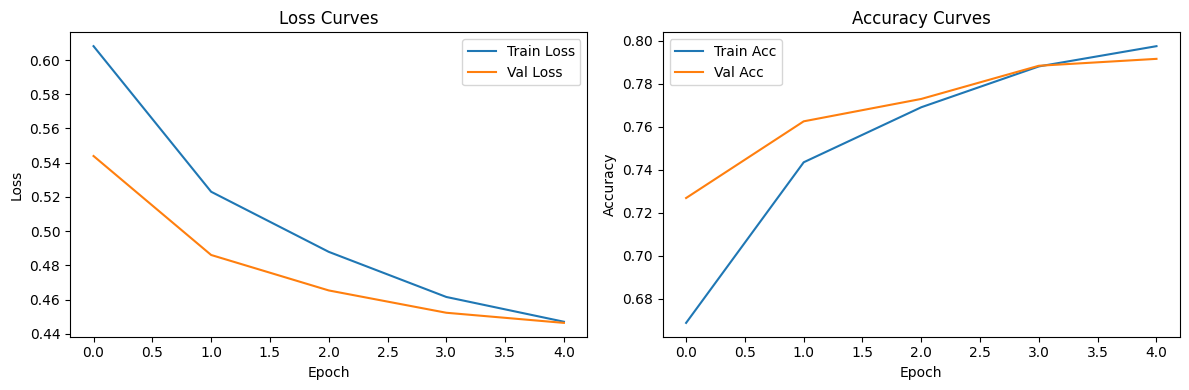

✅ Training looks stable!


In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history['train_acc'], label='Train Acc')
ax2.plot(history['val_acc'], label='Val Acc')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

# Check for overfitting (unstable training)
if history['train_acc'][-1] > history['val_acc'][-1] + 0.1:
    print("⚠️ Warning: Possible overfitting detected!")
    print("Try: More data augmentation, dropout, or fewer epochs")
elif history['val_loss'][-1] > history['val_loss'][0]:
    print("⚠️ Warning: Validation loss increasing!")
    print("Try: Lower learning rate or early stopping")
else:
    print("✅ Training looks stable!")

Step 7: Test on New Images

In [ ]:
# Test prediction function
def predict_image(image_path, model, transform):
    from PIL import Image
    model.eval()

    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    class_names = ['Cat', 'Dog']
    return class_names[predicted.item()], confidence.item()

# Example usage (uncomment when you have a test image):
result, conf = predict_image('download.jpg', model, test_transform)
print(f"Prediction: {result} ({conf*100:.1f}% confident)")

Prediction: Dog (50.8% confident)
